In [1]:
import jsonlines
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import json
from tqdm import tqdm
import colorcet as cc

#### Loading data 

In [2]:
climate_videos_path = "data/climate_videos_v3.jsonl"
all_sample_videos_path = "data/sampled_dataset_1percent.jsonl"

In [3]:
climate_videos_df = pd.read_json(climate_videos_path, lines=True)

#For statistics on the entire dataset, we use the sampled dataset which will not give exact results but will bew statistically relevent
all_videos_df = pd.read_json(all_sample_videos_path, lines=True)

#### What are the categories of Climate Related videos compared to overall youtube? 

In [77]:
all_videos_df['categories'] = all_videos_df['categories'].replace('', 'not specified')
climate_videos_df['categories'] = climate_videos_df['categories'].replace('', 'not specified')


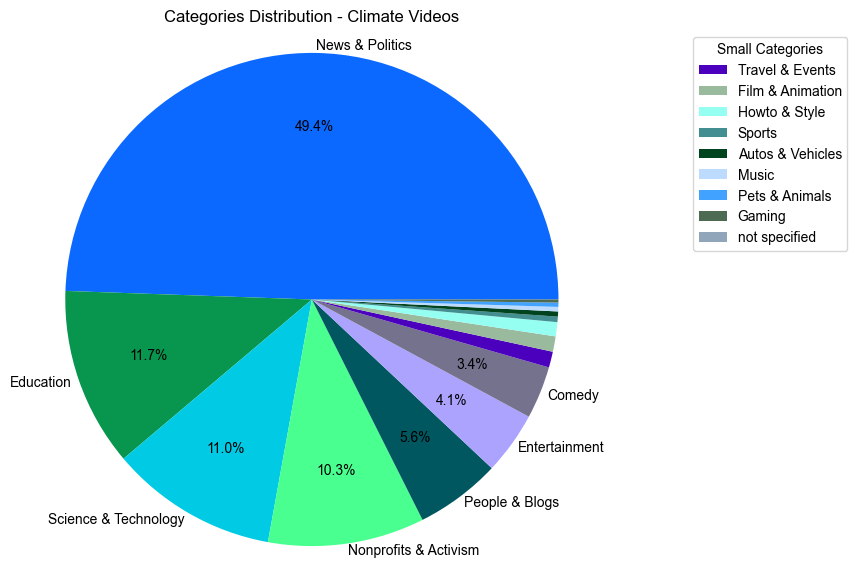

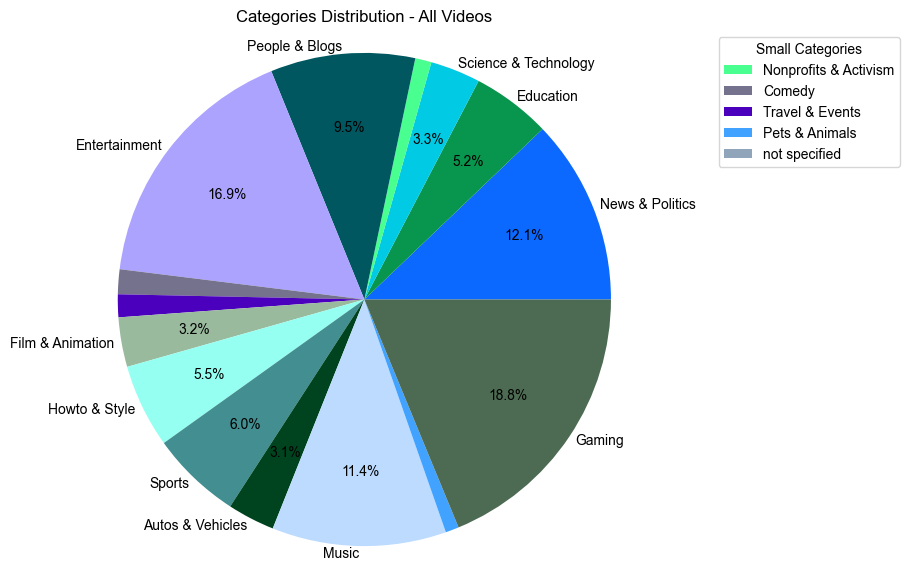

In [110]:
#Coutning the number of videos in each category
category_counts_climate = climate_videos_df['categories'].value_counts()
category_counts_all = all_videos_df['categories'].value_counts()
categories = category_counts_climate.index

#Reordering counts all to match the order of counts_climate and improve visualization
category_counts_all= category_counts_all[categories]

colors = sns.color_palette(cc.glasbey_cool, n_colors=len(category_counts_climate))

# Threshold for small categories
small_category_threshold = 0.03

# Function to split large and small categories for readable plotting
def get_labels(counts):
    big_categories_indexes = [i for i, count in enumerate(counts) if count >= small_category_threshold * counts.sum()]
    small_categories_indexes = [i for i, count in enumerate(counts) if count < small_category_threshold * counts.sum()]
    return big_categories_indexes, small_categories_indexes

# Get labels for climate and all videos
large_labels_climate, small_labels_climate = get_labels(category_counts_climate)
large_labels_all, small_labels_all = get_labels(category_counts_all)

# Function to format autopct so that percentsge of small categories are not shown
def autopct_format(counts, small_category_threshold):
    def inner_autopct(pct):
        total = sum(counts)
        val = int(round(pct*total/100.0))
        if val >= small_category_threshold * total:
            return '{p:.1f}%'.format(p=pct)
        else:
            return ''
    return inner_autopct

# Plotting function
def plot_pie(counts, large_labels_indexes,small_labels_indexes, title):
    plt.figure(figsize=(7, 7))
    large_labels_plot = [cat if i in large_labels_indexes else '' for i,cat in enumerate(counts.index)] # Empty string for small categories on the plot
    wedges, _, _ = plt.pie(counts, autopct=autopct_format(counts, small_category_threshold), labels=large_labels_plot, colors=colors, labeldistance=1.03, pctdistance=0.7)
    plt.title(title)
    plt.axis('equal')
    # Adding a legend for small categories
    small_labels_plot = counts.index[small_labels_indexes]
    small_wedges = [wedges[i] for i in small_labels_indexes]
    plt.legend(small_wedges, small_labels_plot, title="Small Categories", loc="best", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.show()

# Plot for climate videos
plot_pie(category_counts_climate, large_labels_climate,small_labels_climate, 'Categories Distribution - Climate Videos')

# Plot for all videos
plot_pie(category_counts_all, large_labels_all ,small_labels_all, 'Categories Distribution - All Videos')

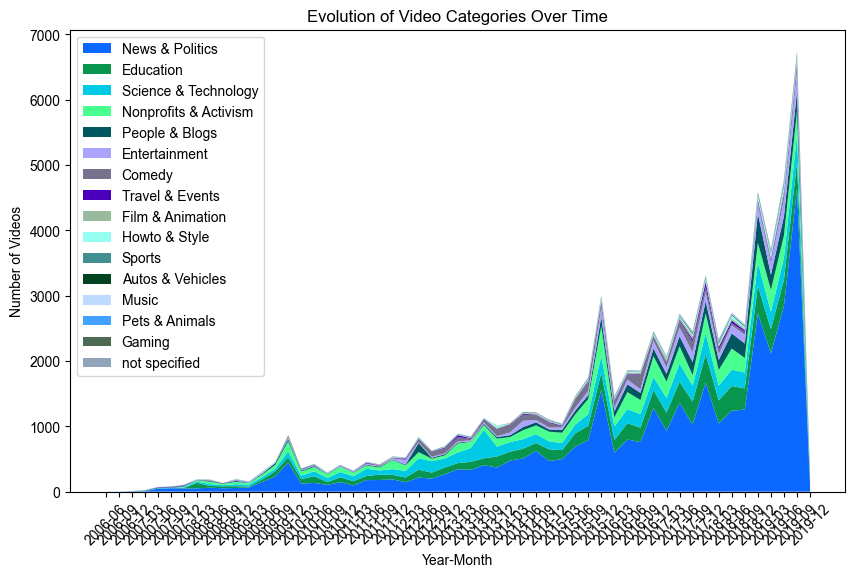

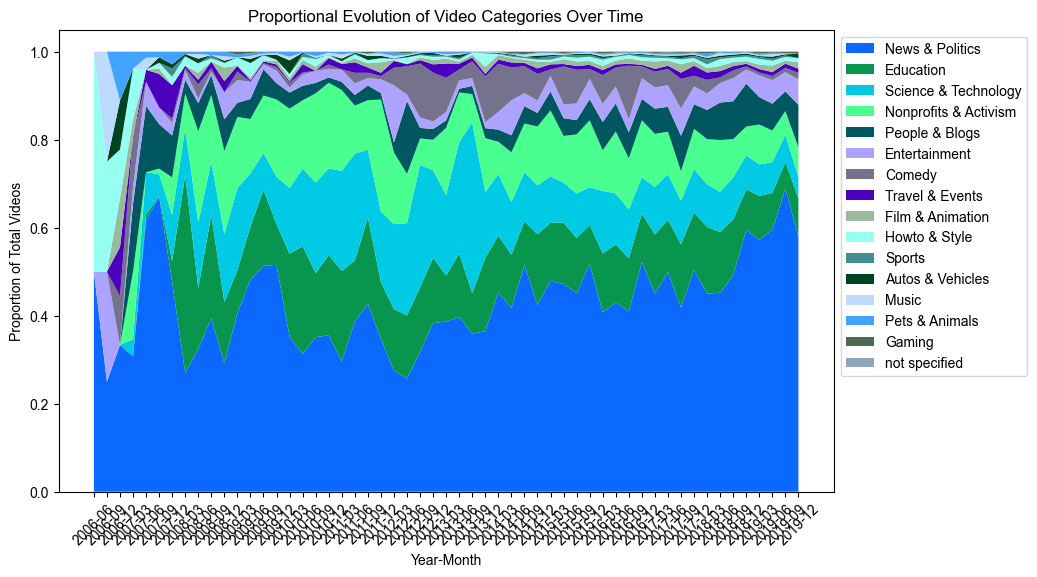

In [121]:

climate_videos_df['year_month'] = pd.to_datetime(climate_videos_df['upload_date']).dt.to_period('Q')

evolution_category_counts_climate = (climate_videos_df[['categories', 'year_month', 'display_id']].groupby(
                                                                    ['categories', 'year_month']).aggregate(
                                                                    'count')).unstack(
                                                                    fill_value=0).stack().reset_index() #add 0 values when there is no video in a category for a given time

evolution_category_counts_climate = evolution_category_counts_climate.rename(columns={'display_id': 'count'})

evols = [evolution_category_counts_climate[evolution_category_counts_climate['categories'] == category]['count'].values for category in categories]
dates = evolution_category_counts_climate['year_month'].dt.strftime('%Y-%m').unique()

# Plotting the evolution of categories over time
plt.figure(figsize=(10, 6))
plt.stackplot(dates, evols, labels=categories, colors=colors)
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.title("Evolution of Video Categories Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Number of Videos")
plt.show()


# Calculate proportions
total_counts = evolution_category_counts_climate.groupby('year_month')['count'].sum() #number of videos added per time unit
proportions = [evol / total_counts for evol in evols]

# Plotting the proportions over time
plt.figure(figsize=(10, 6))
plt.stackplot(dates, proportions, labels=categories, colors=colors)
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Proportional Evolution of Video Categories Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Proportion of Total Videos")
plt.show()



Observations: 
- Different predominant categories, as expected
- Main for climate change: N&P, Education, Science & Tech 

**We study like/dislikes comparison metrics**


$$SLDR(N_{like}, N_{dislike}) =  (-1)^{\delta} \dfrac{\max{(N_{like} , N_{dislike}) + 1}}{\min{(N_{like} , N_{dislike} ) +1 } }$$

In [6]:
def sldr(like_count, dislike_count):
    if like_count == 0 and dislike_count == 0:
        return None
    
    if like_count > dislike_count:
        return (like_count+1)/(dislike_count+1)
    else :
        return - (dislike_count+1)/(like_count+1)
      

In [7]:
for df in [climate_videos_df, all_videos_df]:
    df['engagement_rate'] = (df['like_count'] + df['dislike_count']) / df['view_count']
    df['like_percentage'] = (df['like_count'] / (df['like_count'] + df['dislike_count']))
    df['sldr'] = df.apply(lambda row: sldr(row['like_count'], row['dislike_count']), axis=1)

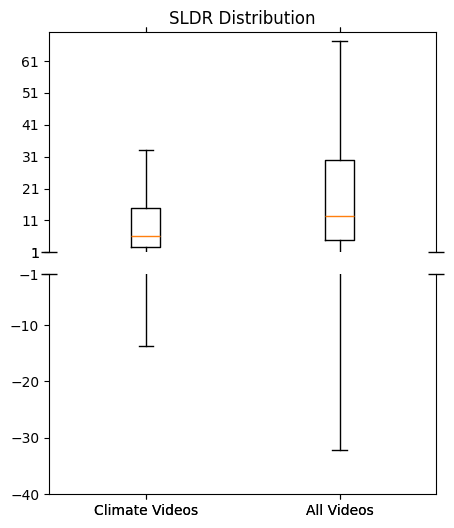

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 6))
fig.subplots_adjust(hspace=0.1)  # adjust space between axes

# plot the same data on both axes
ax1.boxplot([climate_videos_df['sldr'].dropna(), all_videos_df['sldr'].dropna()], showfliers=False)
ax2.boxplot([climate_videos_df['sldr'].dropna(), all_videos_df['sldr'].dropna()], showfliers=False)

# zoom-in / limit the view to different portions of the data
ax1.set_title('SLDR Distribution')
ax1.set_ylim(1, 70)  # outliers only
y_ticks_high = list(range(1, 70, 10))
y_ticks_high.append(1)
ax1.set_yticks(y_ticks_high)  # Set y-axis ticks

ax2.set_ylim(-40, -1)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
y_ticks_low  = list(range(-40, 0, 10))
y_ticks_low.append(-1)
ax2.set_yticks(y_ticks_low)
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
#ax1.text(1, climate_mean, f"Mean: {climate_mean:.2f}", ha='center', va='bottom', color='red')
#ax1.text(2, all_mean, f"Mean: {all_mean:.2f}", ha='center', va='bottom', color='red')

ax1.set_xticklabels(['','','Climate Videos', 'All Videos'])

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = 0  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)

ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)




We can see that the like ratio is lower for climate videos. Hence they are more dabatable. And it goes much lower...

Let's now study by categories

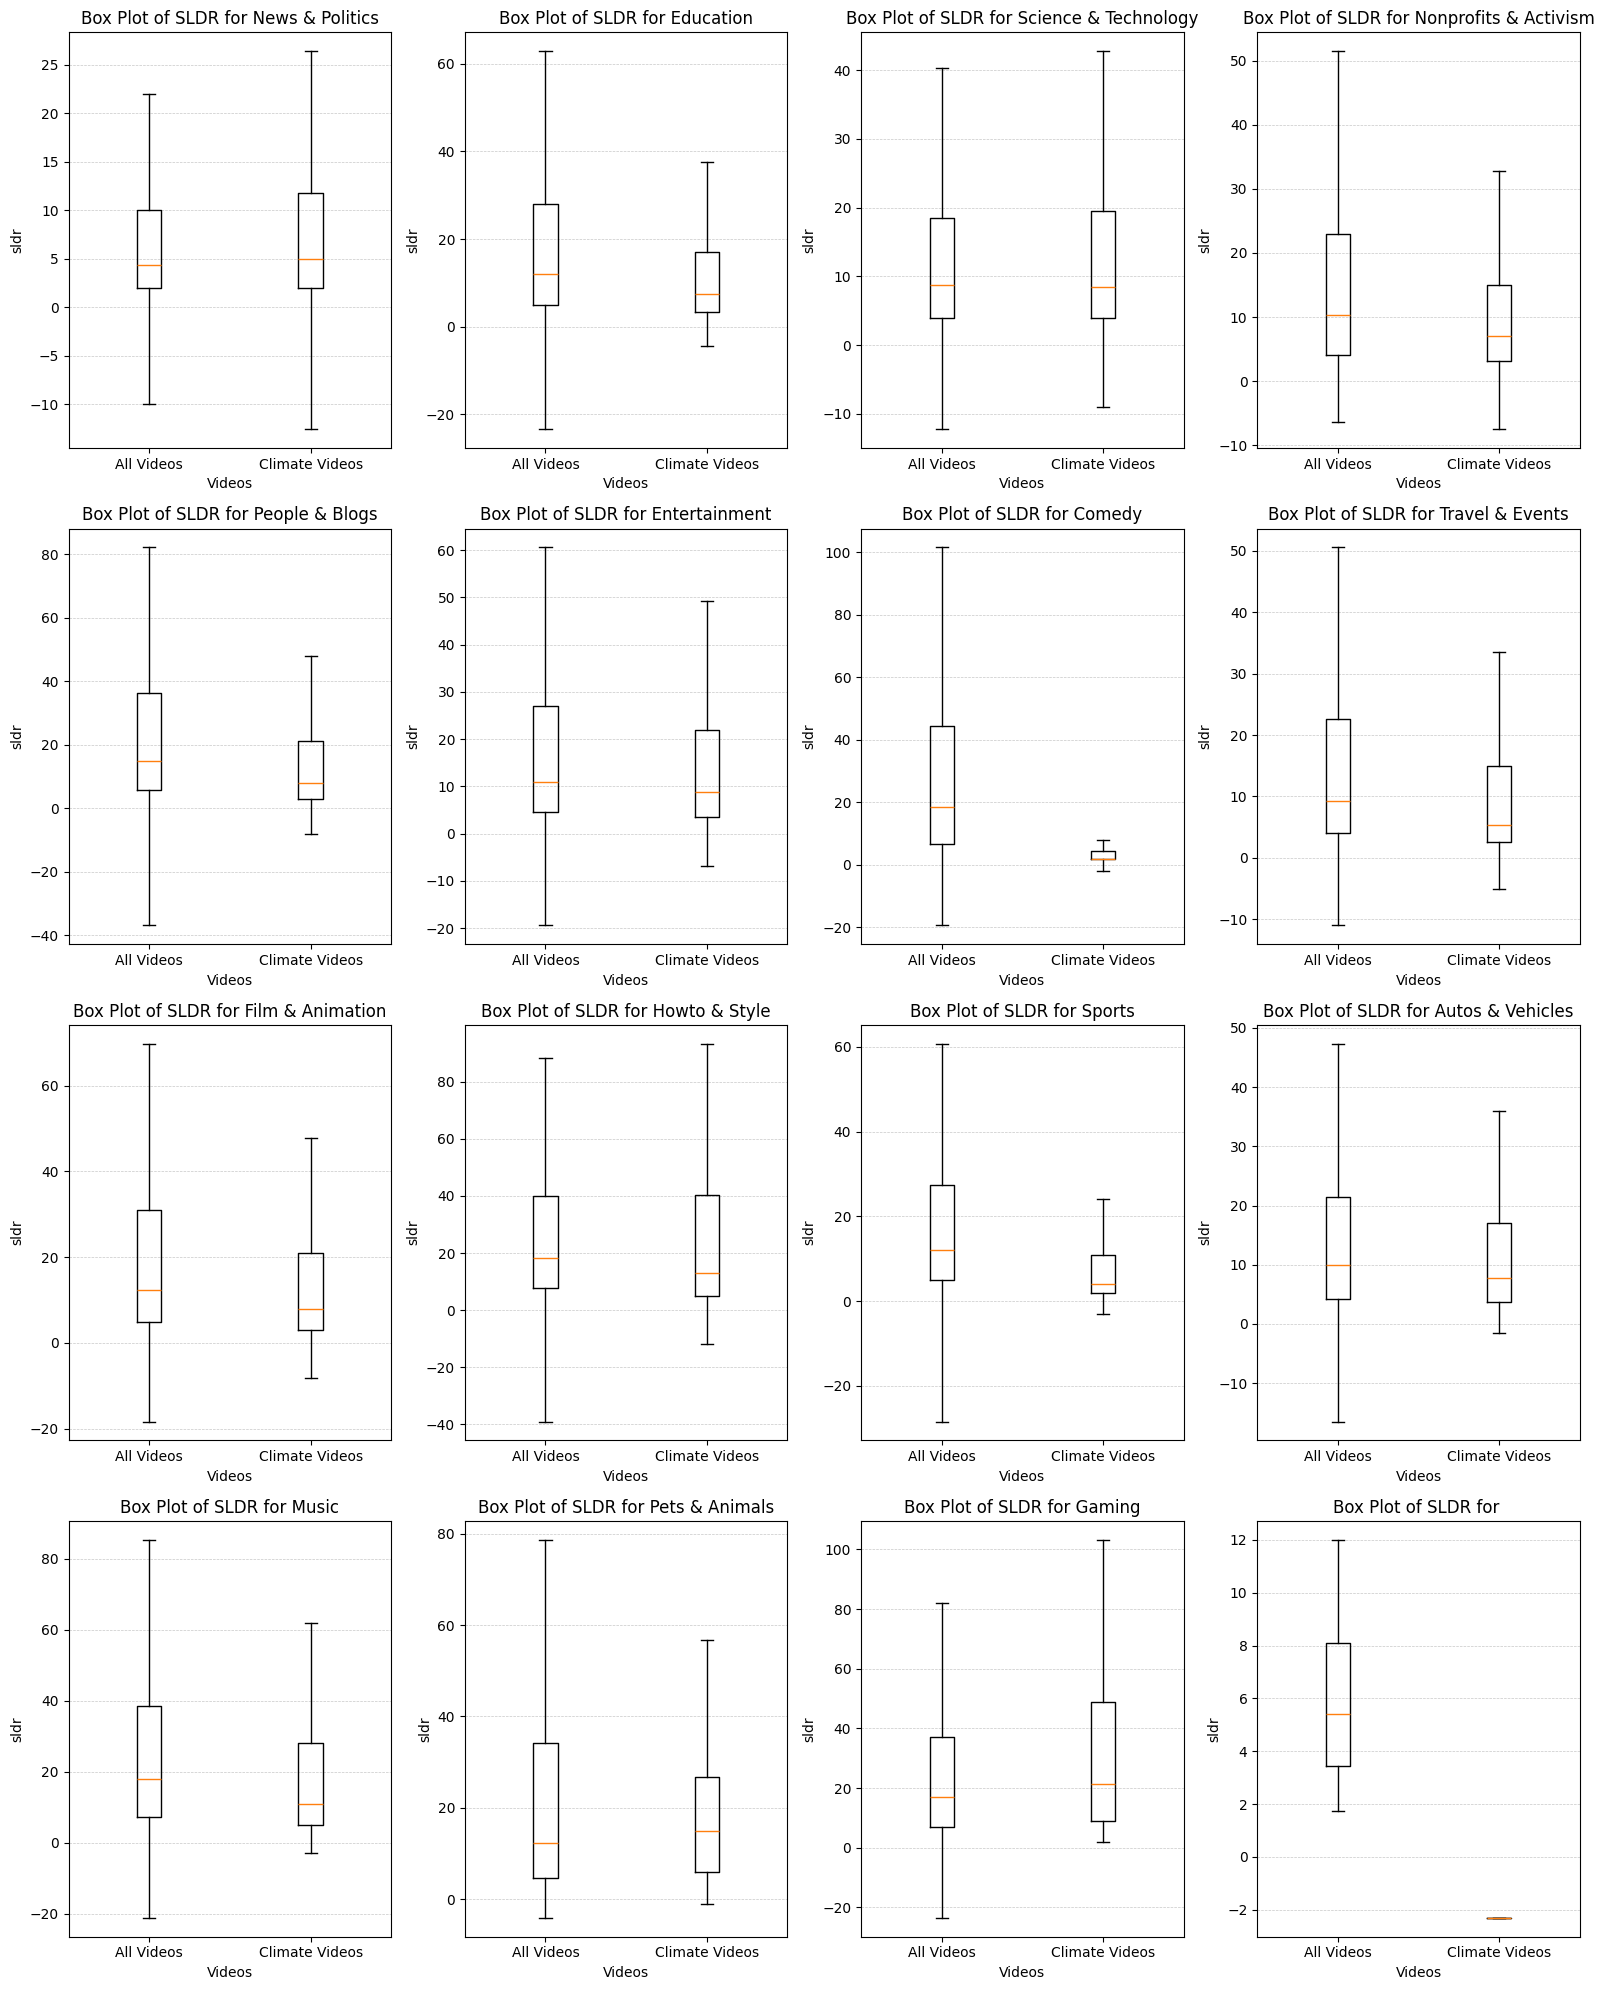

In [9]:
plt.figure(figsize=(16, 20))  # Adjust the figure size as desired

num_categories = len(categories)
num_columns = num_categories // 4  # Number of columns in the subplot grid
num_rows = num_categories // 4   # Number of rows in the subplot grid

for i, category in enumerate(categories):
    plt.subplot(num_rows, num_columns, i+1)
    
    ndlis_all = all_videos_df.query(f"categories == '{category}'")['sldr'].dropna()
    ndlis_climate = climate_videos_df.query(f"categories == '{category}'")['sldr'].dropna()
    
    plt.boxplot([ndlis_all, ndlis_climate], showfliers=False)
    
    plt.xlabel('Videos')
    plt.ylabel('sldr')
    plt.title(f'Box Plot of SLDR for {category}')
    
    plt.grid(axis='y', which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Add x labels
    plt.xticks([1, 2], ['All Videos', 'Climate Videos'])

plt.tight_layout()
plt.show()

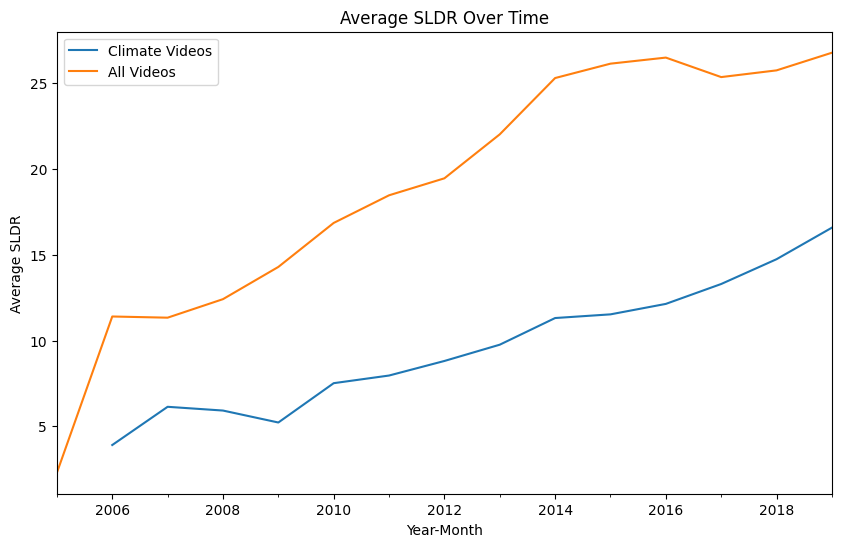

In [10]:
for df in [climate_videos_df, all_videos_df]:
    df['upload_date'] = pd.to_datetime(df['upload_date'])
    df['year_month'] = df['upload_date'].dt.to_period('Y')
    average_like_ratio = df.groupby('year_month')['sldr'].mean()
    average_like_ratio.plot(kind='line', figsize=(10, 6))

plt.xlabel('Year-Month')
plt.ylabel('Average SLDR')
plt.title('Average SLDR Over Time')

# Add legend
plt.legend(['Climate Videos', 'All Videos'])

plt.show()


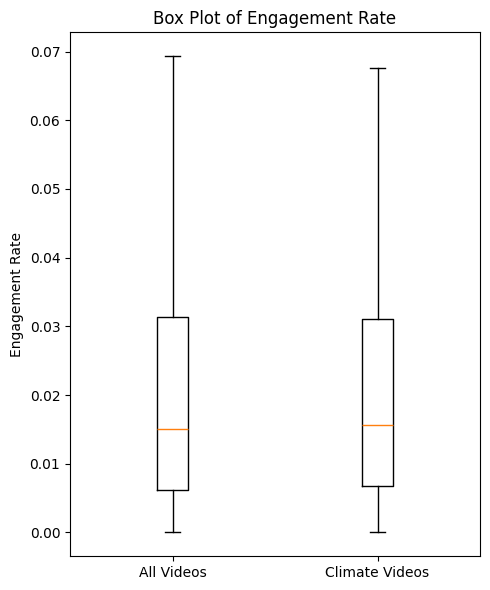

In [11]:
plt.figure(figsize=(5, 6))
plt.boxplot([all_videos_df['engagement_rate'].dropna(),climate_videos_df['engagement_rate'].dropna()], showfliers=False)
plt.ylabel('Engagement Rate')
plt.title('Box Plot of Engagement Rate') 
#plt.grid(axis='y', which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    
# Add x labels
plt.xticks([1, 2], ['All Videos', 'Climate Videos'])
plt.tight_layout()
plt.show()

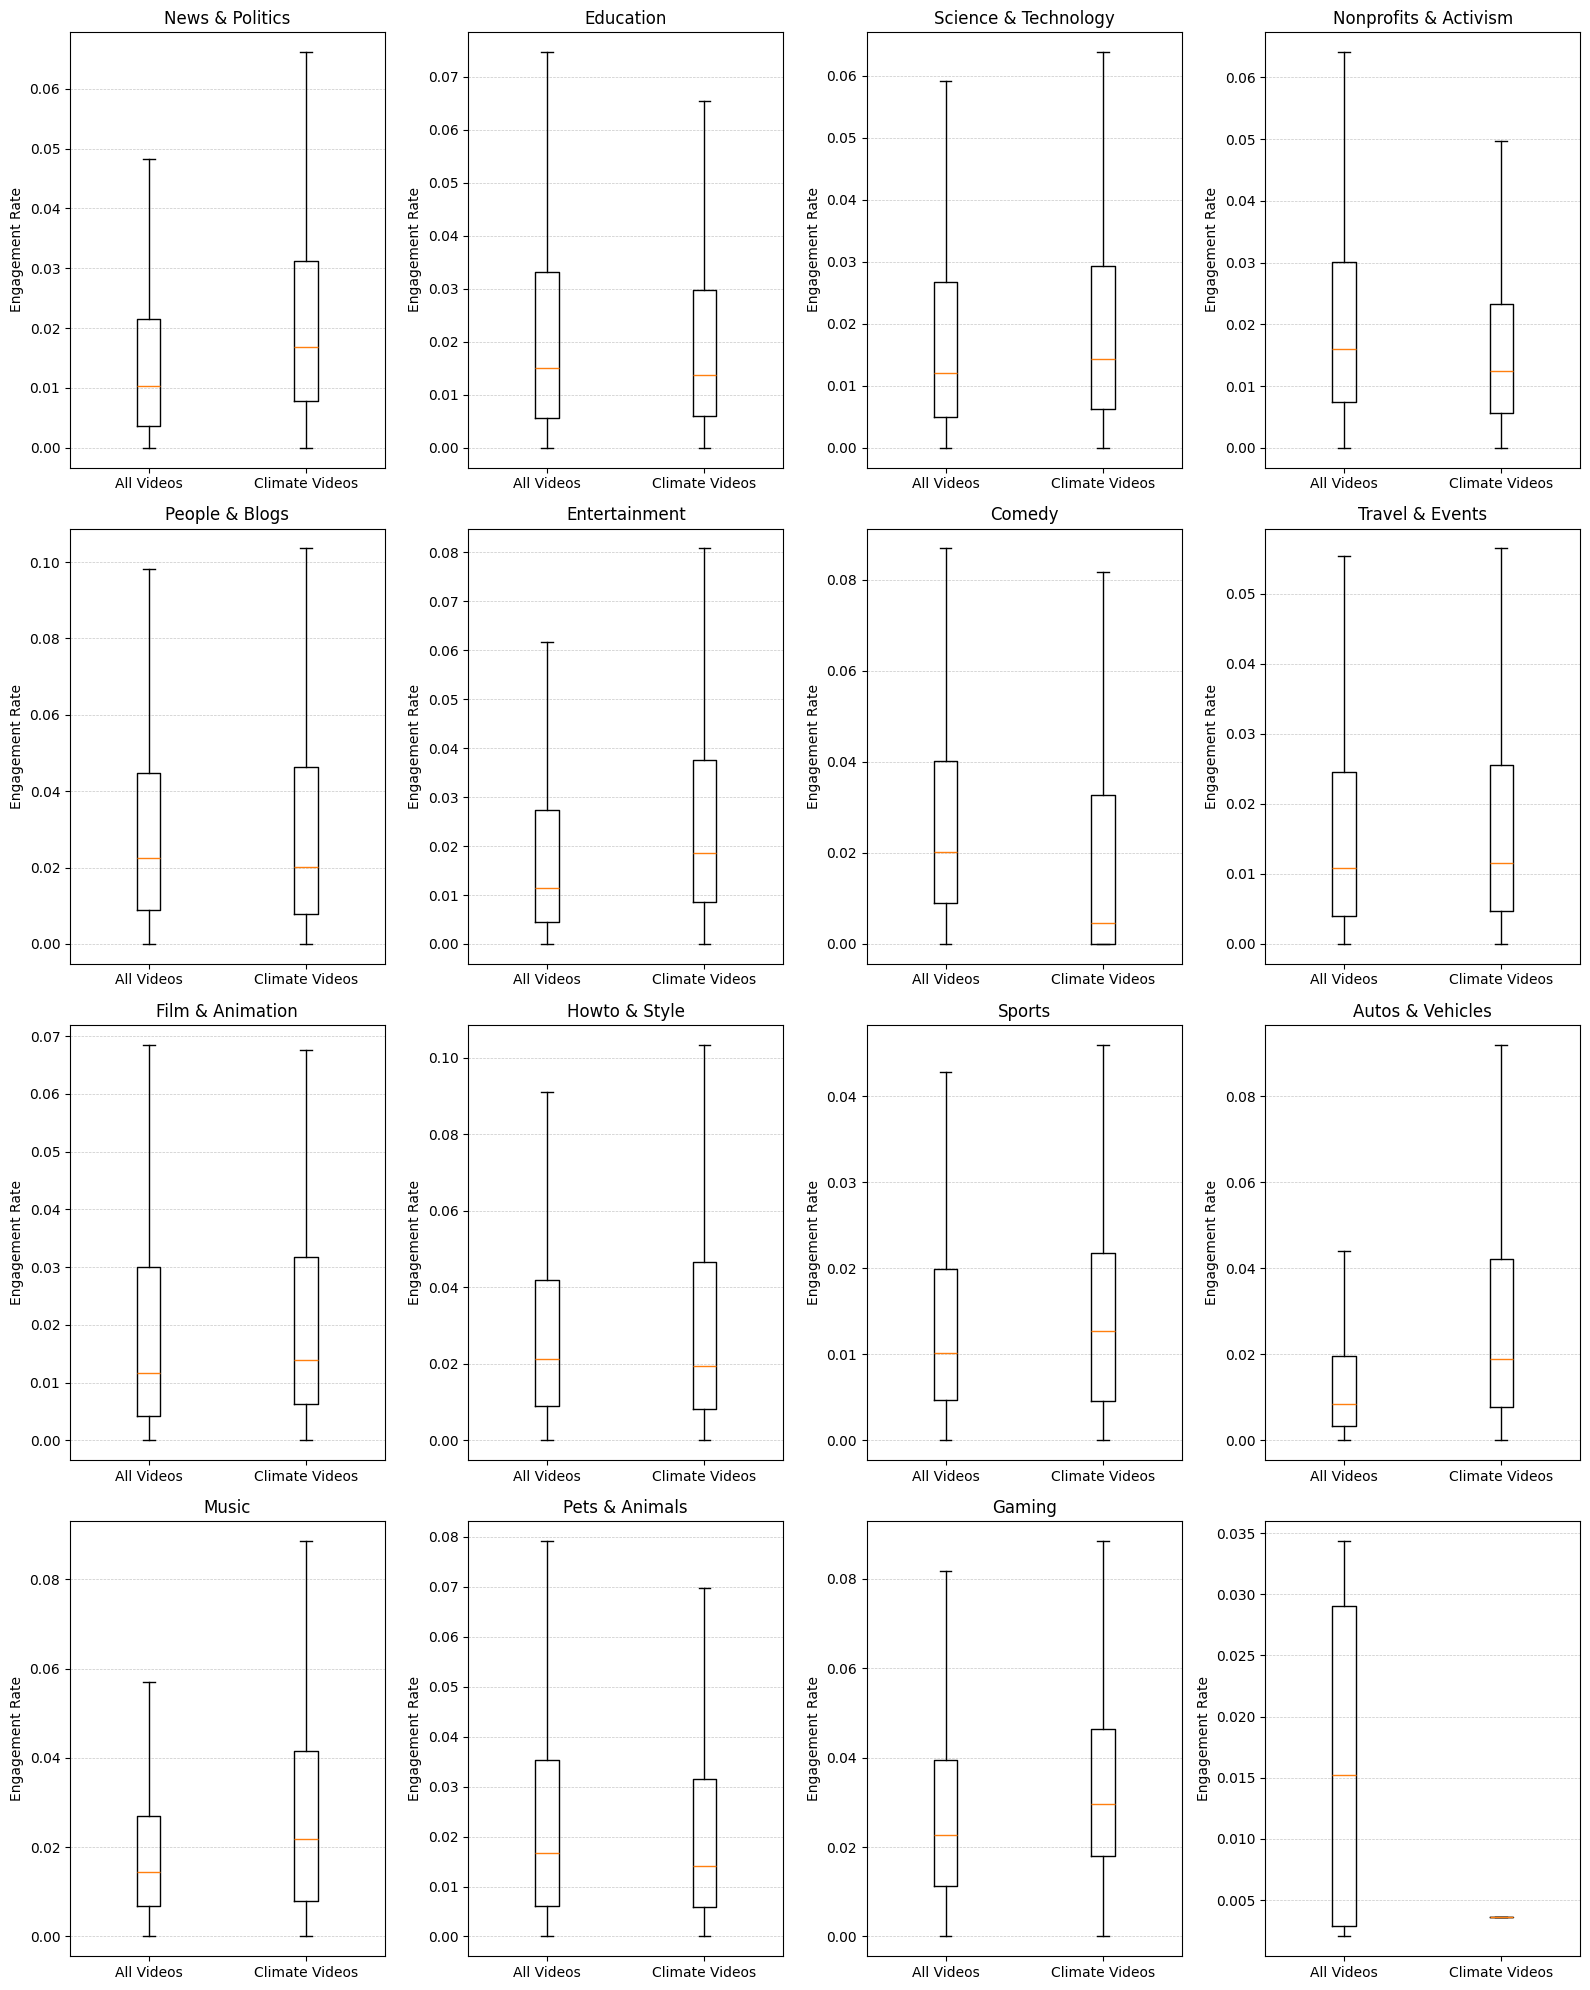

In [12]:
plt.figure(figsize=(16, 20))  # Adjust the figure size as desired

num_categories = len(categories)
num_columns = num_categories // 4  # Number of columns in the subplot grid
num_rows = num_categories // 4   # Number of rows in the subplot grid

for i, category in enumerate(categories):
    plt.subplot(num_rows, num_columns, i+1)
    
    engagement_rate_all = all_videos_df.query(f"categories == '{category}'")['engagement_rate'].dropna()
    engagement_rate_climate = climate_videos_df.query(f"categories == '{category}'")['engagement_rate'].dropna()
    
    plt.boxplot([engagement_rate_all, engagement_rate_climate], showfliers=False)
    plt.ylabel('Engagement Rate')
    plt.title(category)
    
    plt.grid(axis='y', which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Add x labels
    plt.xticks([1, 2], ['All Videos', 'Climate Videos'])

plt.tight_layout()
plt.show()

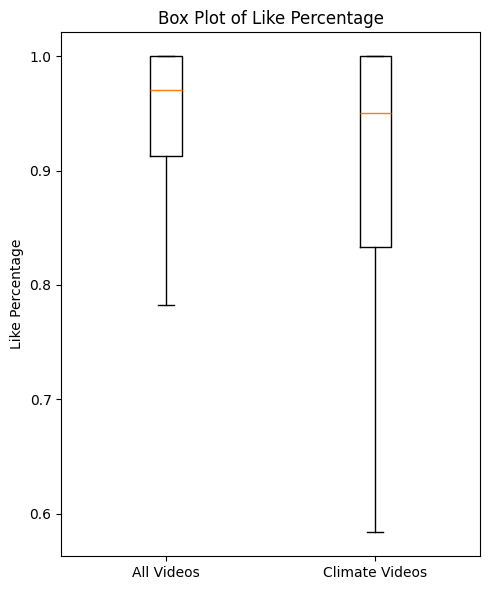

In [13]:
plt.figure(figsize=(5, 6))
plt.boxplot([all_videos_df['like_percentage'].dropna(), climate_videos_df['like_percentage'].dropna()], showfliers=False)
plt.ylabel('Like Percentage')
plt.title('Box Plot of Like Percentage') 
#plt.grid(axis='y', which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    
# Add x labels
plt.xticks([1, 2], ['All Videos', 'Climate Videos'])
plt.tight_layout()
plt.show()

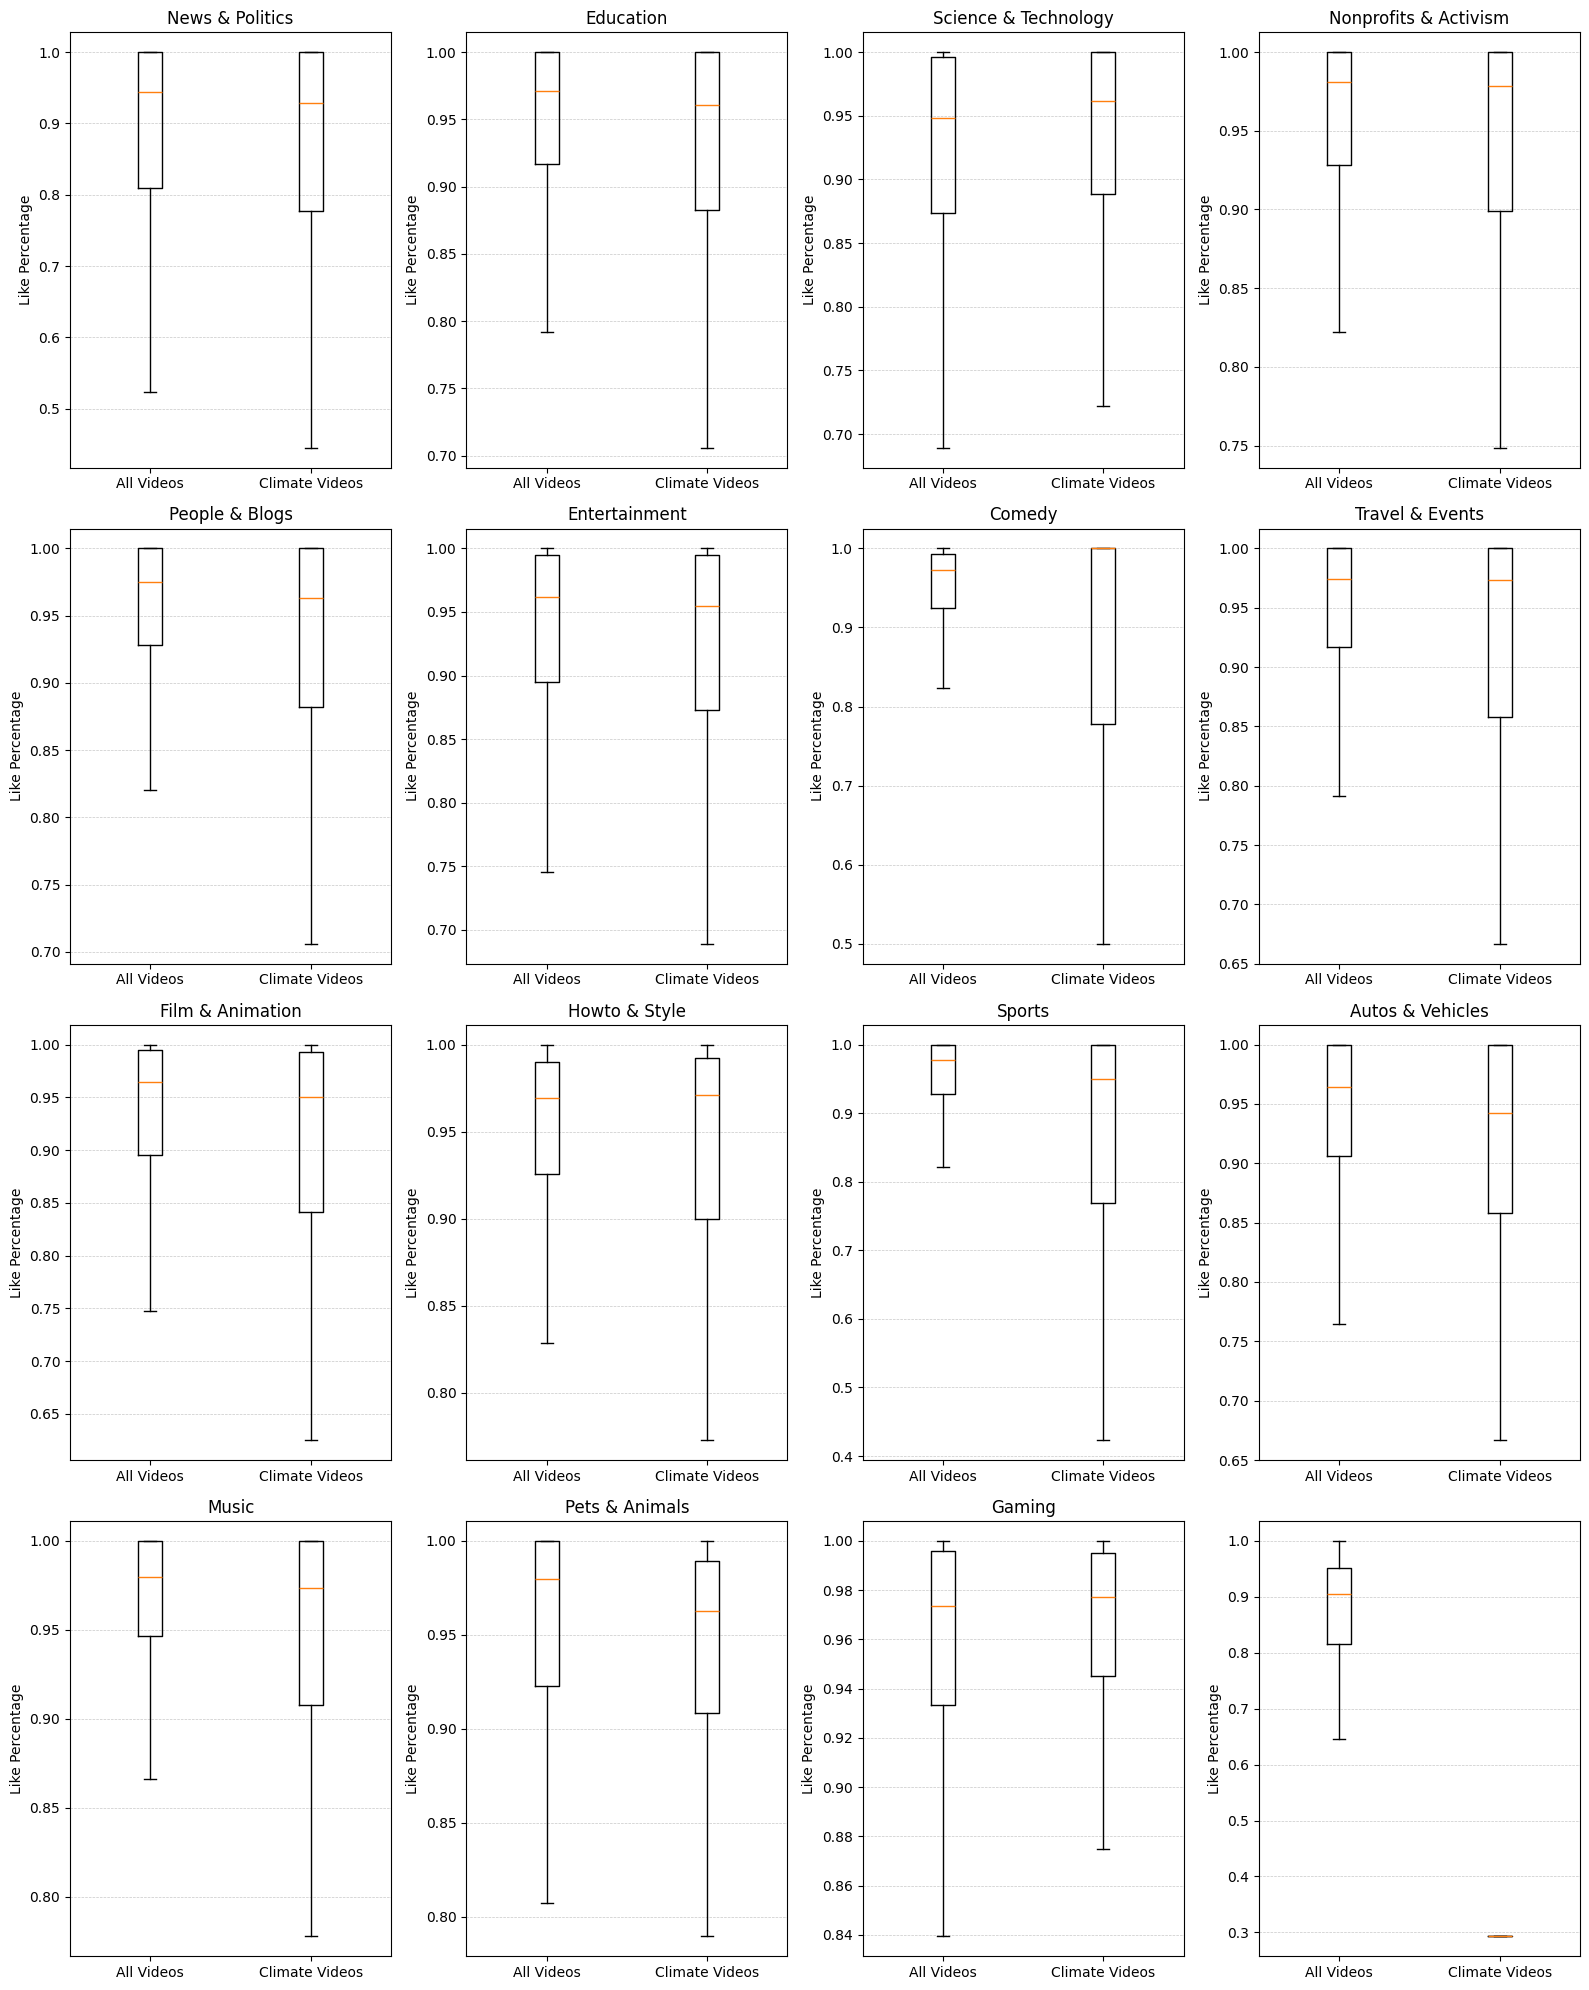

In [14]:
plt.figure(figsize=(16, 20))  # Adjust the figure size as desired

num_categories = len(categories)
num_columns = num_categories // 4  # Number of columns in the subplot grid
num_rows = num_categories // 4   # Number of rows in the subplot grid

for i, category in enumerate(categories):
    plt.subplot(num_rows, num_columns, i+1)
    
    like_percentage_all = all_videos_df.query(f"categories == '{category}'")['like_percentage'].dropna()
    like_percentage_climate = climate_videos_df.query(f"categories == '{category}'")['like_percentage'].dropna()
    
    plt.boxplot([like_percentage_all, like_percentage_climate], showfliers=False)
    plt.ylabel('Like Percentage')
    plt.title(category)
    
    plt.grid(axis='y', which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Add x labels
    plt.xticks([1, 2], ['All Videos', 'Climate Videos'])

plt.tight_layout()
plt.show()

Climate concerned people growing, but climato skeptical vids ?